In [1]:
# Step 1: Import libraries for MobileNetV3 model training and visualization

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import cv2

# Specific import for MobileNetV3
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


In [2]:
# Step 3: Hyperparameters for MobileNetV3
BATCH_SIZE = 32

# Recommended IMAGE_SIZE is 224 for pretrained MobileNetV3
IMAGE_SIZE = 224  # change from 256 if you want to fully match ImageNet weights
CHANNELS = 3
EPOCHS = 60
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the dataset path in Google Drive
# Change this path to where your dataset folder is stored in your Drive
DATA_PATH = '/content/drive/MyDrive/Tea Leaf Updated'

Mounted at /content/drive


In [4]:
#Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
# Step 6: Load dataset for MobileNetV3
data_dir = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 2497 files belonging to 4 classes.


In [6]:
class_names = data_dir.class_names
print(f"Class names: {class_names}")
print(f"Dataset len: {len(data_dir)}")

Class names: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
Dataset len: 79


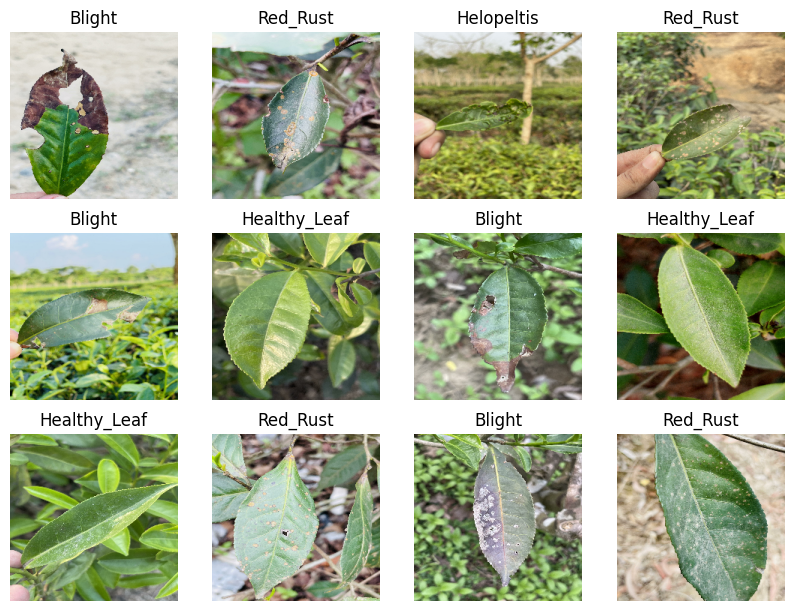

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data_dir.take(2):
    for i in range(12):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
import os
import cv2

def load_data(data_dir, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Load and preprocess data from directory for MobileNetV3"""
    images = []
    labels = []
    class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} not found")
            continue

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

        print(f"Loading {len(image_files)} images from {class_name}")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32)

                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    # Apply MobileNetV3 preprocessing on all images at once (scales pixels to [-1, 1])
    images = preprocess_input(images)

    return images, labels, class_names


In [9]:
X, y, class_names = load_data(DATA_PATH)

Loading 555 images from Blight
Loading 650 images from Healthy_Leaf
Loading 675 images from Helopeltis
Loading 617 images from Red_Rust


In [10]:
print(f"Total samples: {len(X)}")
print(f"Image shape: {X.shape}")
print(f"Classes: {class_names}")

Total samples: 2497
Image shape: (2497, 224, 224, 3)
Classes: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']


In [11]:
# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"{class_names[class_idx]}: {count} samples")


Class distribution:
Blight: 555 samples
Healthy_Leaf: 650 samples
Helopeltis: 675 samples
Red_Rust: 617 samples


In [12]:
# Split data: 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Train samples: 1997
Validation samples: 250
Test samples: 250


In [13]:
# Data augmentation for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    # brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation and test
val_datagen = keras.preprocessing.image.ImageDataGenerator()

In [14]:
# Create data generators
batch_size = BATCH_SIZE
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
test_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

print(f"\nTrain generator batches: {len(train_generator)}")
print(f"Validation generator batches: {len(val_generator)}")
print(f"Test generator batches: {len(test_generator)}")


Train generator batches: 63
Validation generator batches: 8
Test generator batches: 8


In [15]:
def create_tea_leaf_mobilenetv3_model(input_shape=(224, 224, 3), num_classes=5, dropout_rate=0.3, fine_tune_at=None):
    # Load MobileNetV3 base model with pretrained weights, excluding top classification layer
    base_model = MobileNetV3Large(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # freeze base model initially

    inputs = layers.Input(shape=input_shape)
    x = preprocess_input(inputs)  # preprocess inputs as MobileNetV3 expects

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    # Optionally unfreeze layers for fine-tuning
    if fine_tune_at is not None:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

    return model

In [16]:
# Create and compile MobileNetV3 model
from tensorflow.keras import layers, models

model = create_tea_leaf_mobilenetv3_model(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    num_classes=len(class_names),
    dropout_rate=0.3,
    fine_tune_at=100  # or None if you want to train only head initially
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Model summary
model.summary()
print(f"Total parameters: {model.count_params():,}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 2,815,844 (10.74 MB)

 Non-trainable params: 184,352 (720.12 KB)

Total parameters: 3,000,196


In [18]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False
    )
]

In [19]:
print("\nStarting training...")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
    # Uncomment below lines if your generators don’t infer steps automatically
    # steps_per_epoch=len(X_train) // BATCH_SIZE,
    # validation_steps=len(X_val) // BATCH_SIZE,
)



Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7258 - loss: 0.7191

63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 751ms/step - accuracy: 0.7274 - loss: 0.7152 - val_accuracy: 0.7880 - val_loss: 1.2350 - learning_rate: 0.0010
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9216 - loss: 0.2356

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.9219 - loss: 0.2349 - val_accuracy: 0.8720 - val_loss: 0.7011 - learning_rate: 0.0010
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.9592 - loss: 0.1150 - val_accuracy: 0.6320 - val_loss: 8.8514 - learning_rate: 0.0010
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.9611 - loss: 0.1198 - val_accuracy: 0.5480 - val_loss: 10.2801 - learning_rate: 0.0010
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.9659 - loss: 0.0965 - val_accuracy: 0.7680 - val_loss: 4.4571 - learning_rate: 0.0010
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.9419 - loss: 0.1672 - val_accuracy: 0.8720 - val_loss: 0.7135 - learning_rate: 0.0010
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9708 - loss: 0.0731

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - accuracy: 0.9708 - loss: 0.0730 - val_accuracy: 0.9200 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.9851 - loss: 0.0488 - val_accuracy: 0.8400 - val_loss: 2.1055 - learning_rate: 0.0010
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9887 - loss: 0.0300 - val_accuracy: 0.8600 - val_loss: 0.4730 - learning_rate: 0.0010
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.9815 - loss: 0.0434 - val_accuracy: 0.7760 - val_loss: 1.4246 - learning_rate: 0.0010
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.9846 - loss: 0.0394 - val_accuracy: 0.6920 - val_loss: 8.4850 - learning_rate: 0.0010
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - accuracy: 0.9891 - loss: 0.0358 - val_accuracy: 0.9040 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.9846 - loss: 0.0505 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.9975 - loss: 0.0141 - val_accuracy: 0.9400 - val_loss: 0.4050 - learning_rate: 5.0000e-04
Epoch 19/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9996 - loss: 0.0045

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9600 - val_loss: 0.2438 - learning_rate: 5.0000e-04
Epoch 20/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 363ms/step - accuracy: 0.9982 - loss: 0.0085 - val_accuracy: 0.9440 - val_loss: 0.3853 - learning_rate: 5.0000e-04
Epoch 21/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9961 - loss: 0.0155 - val_accuracy: 0.9280 - val_loss: 0.7171 - learning_rate: 5.0000e-04
Epoch 22/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 412ms/step - accuracy: 0.9983 - loss: 0.0111 - val_accuracy: 0.9560 - val_loss: 0.4114 - learning_rate: 5.0000e-04
Epoch 23/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9999 - loss: 0.0046

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9999 - loss: 0.0046 - val_accuracy: 0.9640 - val_loss: 0.5522 - learning_rate: 5.0000e-04
Epoch 24/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9600 - val_loss: 0.3943 - learning_rate: 5.0000e-04
Epoch 25/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9996 - loss: 0.0026

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9680 - val_loss: 0.2565 - learning_rate: 2.5000e-04
Epoch 26/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.9981 - loss: 0.0059 - val_accuracy: 0.9680 - val_loss: 0.2407 - learning_rate: 2.5000e-04
Epoch 27/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9968 - loss: 0.0057

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.9969 - loss: 0.0057 - val_accuracy: 0.9720 - val_loss: 0.2066 - learning_rate: 2.5000e-04
Epoch 28/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 350ms/step - accuracy: 0.9984 - loss: 0.0040 - val_accuracy: 0.9680 - val_loss: 0.1723 - learning_rate: 2.5000e-04
Epoch 29/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9993 - loss: 0.0037

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.9760 - val_loss: 0.1339 - learning_rate: 2.5000e-04
Epoch 30/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.9971 - loss: 0.0066 - val_accuracy: 0.9720 - val_loss: 0.1351 - learning_rate: 2.5000e-04
Epoch 31/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9680 - val_loss: 0.2132 - learning_rate: 2.5000e-04
Epoch 32/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9760 - val_loss: 0.1613 - learning_rate: 2.5000e-04
Epoch 33/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9560 - val_loss: 0.4545 - learning_rate: 2.5000e-04
Epoch 34/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9960 - loss: 0.0077

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.9960 - loss: 0.0077 - val_accuracy: 0.9800 - val_loss: 0.1337 - learning_rate: 2.5000e-04
Epoch 35/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9760 - val_loss: 0.1187 - learning_rate: 2.5000e-04
Epoch 36/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9760 - val_loss: 0.1054 - learning_rate: 2.5000e-04
Epoch 37/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9800 - val_loss: 0.1015 - learning_rate: 2.5000e-04
Epoch 38/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9800 - val_loss: 0.0957 - learning_rate: 2.5000e-04
Epoch 39/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accuracy: 0.9760 - val_loss: 0.2143 - learning_rate: 2.5000e-04
Epoch 40/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9840 - val_loss: 0.0993 - learning_rate: 2.5000e-04
Epoch 48/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9800 - val_loss: 0.1119 - learning_rate: 2.5000e-04
Epoch 49/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.9979 - loss: 0.0050 - val_accuracy: 0.9760 - val_loss: 0.1393 - learning_rate: 2.5000e-04
Epoch 50/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9800 - val_loss: 0.1269 - learning_rate: 2.5000e-04
Epoch 51/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9760 - val_loss: 0.1366 - learning_rate: 2.5000e-04
Epoch 52/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 355ms/step - accuracy: 0.9989 - loss: 0.0025 - val_accuracy: 0.9800 - val_loss: 0.1283 - learning_rate: 1.2500e-04
Epoch 53/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy

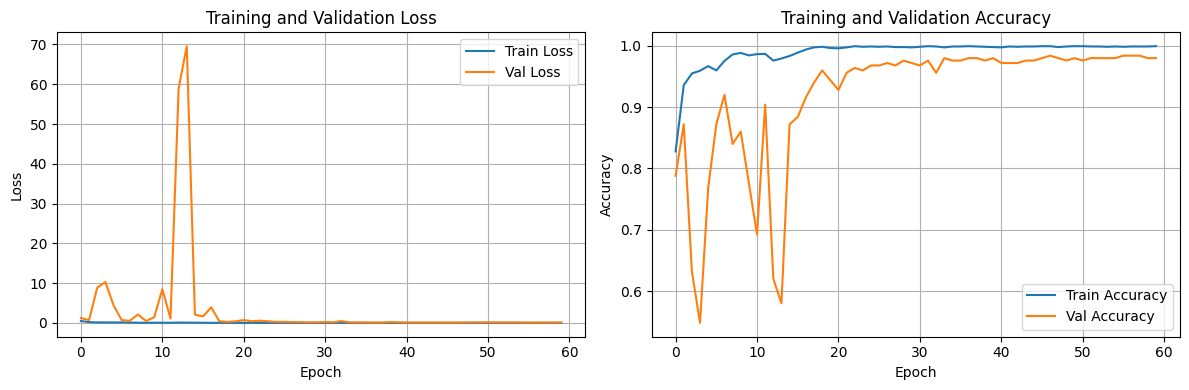

In [20]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 652ms/step
Classification Report:

              precision    recall  f1-score   support

      Blight     0.9821    1.0000    0.9910        55
Healthy_Leaf     0.9848    1.0000    0.9924        65
  Helopeltis     1.0000    0.9706    0.9851        68
    Red_Rust     0.9677    0.9677    0.9677        62

    accuracy                         0.9840       250
   macro avg     0.9837    0.9846    0.9840       250
weighted avg     0.9841    0.9840    0.9840       250



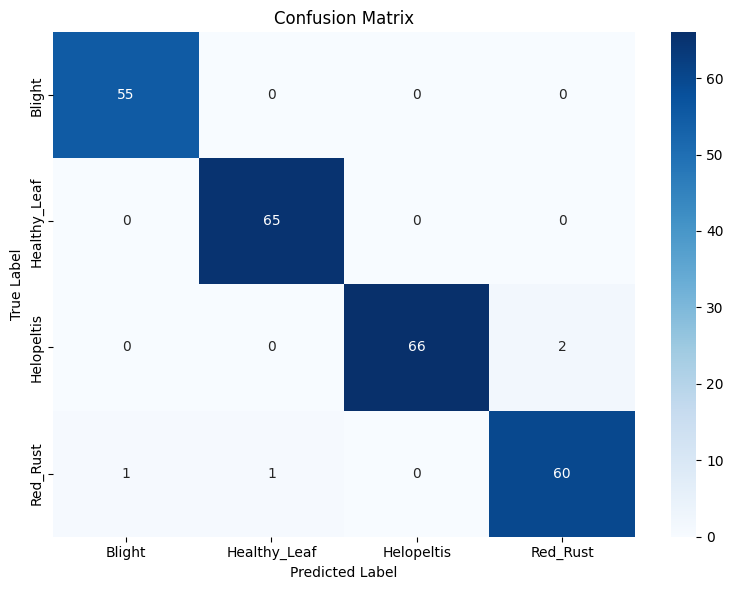

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


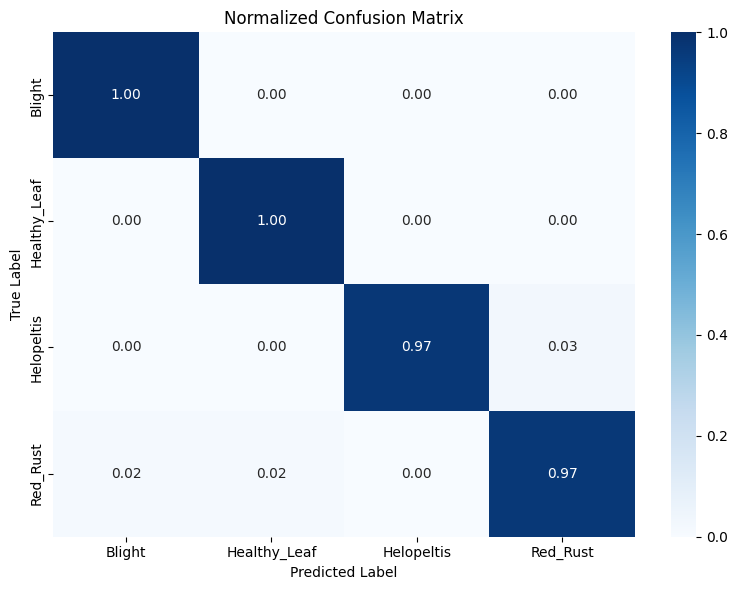

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix (raw values):\n", cm_normalized)


Normalized Confusion Matrix (raw values):
 [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.97058824 0.02941176]
 [0.01612903 0.01612903 0.         0.96774194]]


In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix row-wise
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to pandas DataFrame for nice printing with class labels
df_cm = pd.DataFrame(cm_normalized, index=class_names, columns=class_names)

print("Normalized Confusion Matrix:\n")
print(df_cm)


Normalized Confusion Matrix:

                Blight  Healthy_Leaf  Helopeltis  Red_Rust
Blight        1.000000      0.000000    0.000000  0.000000
Healthy_Leaf  0.000000      1.000000    0.000000  0.000000
Helopeltis    0.000000      0.000000    0.970588  0.029412
Red_Rust      0.016129      0.016129    0.000000  0.967742


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix (raw counts)
cm = confusion_matrix(y_true, y_pred)

# Convert to pandas DataFrame for pretty printing with class labels
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

print("Confusion Matrix (Raw Counts):\n")
print(df_cm)


Confusion Matrix (Raw Counts):

              Blight  Healthy_Leaf  Helopeltis  Red_Rust
Blight            55             0           0         0
Healthy_Leaf       0            65           0         0
Helopeltis         0             0          66         2
Red_Rust           1             1           0        60


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


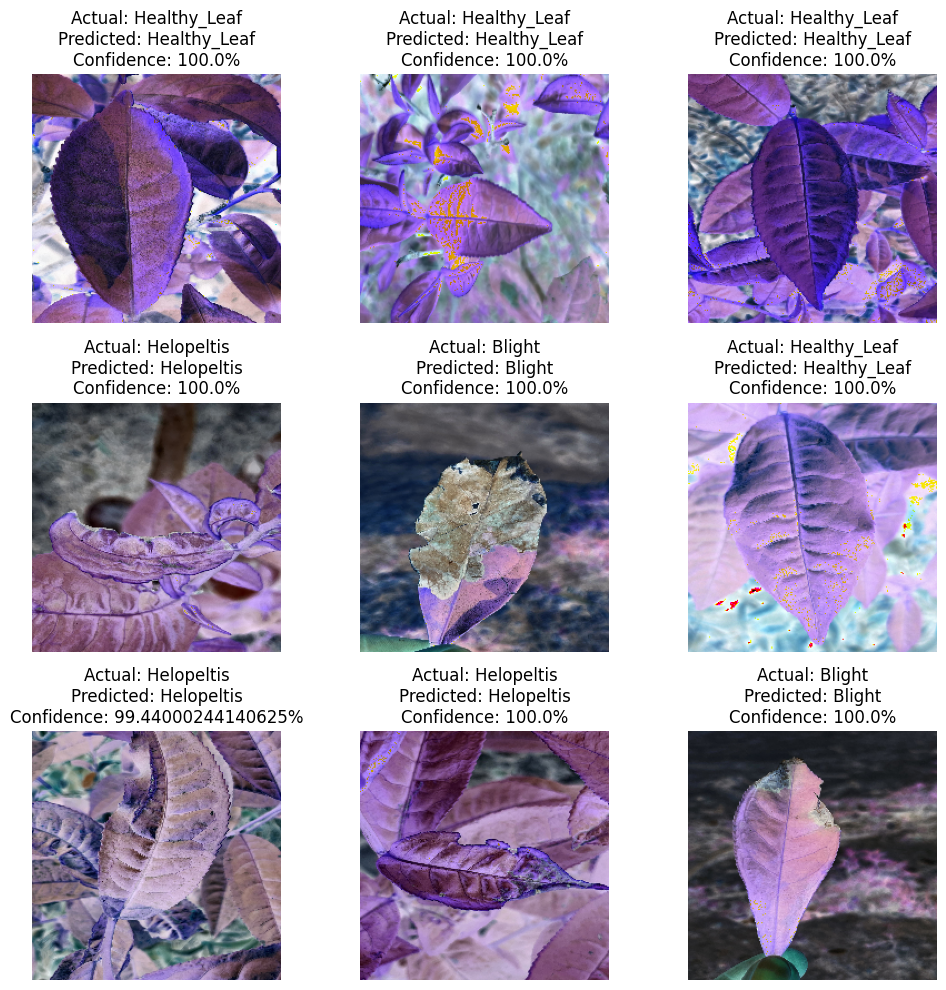

In [27]:

class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
def predict(model, img):
    img_array = tf.expand_dims(img, 0)  # Add batch dimension
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    return predicted_class, confidence

# Get one batch from test_generator
images, labels = next(test_generator)

# Plot 9 images with predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)

    # Denormalize the image
    img = (images[i] * 255).astype("uint8")

    # Get actual and predicted classes
    actual_class = class_names[int(labels[i])]
    predicted_class, confidence = predict(model, images[i])

    plt.imshow(img)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


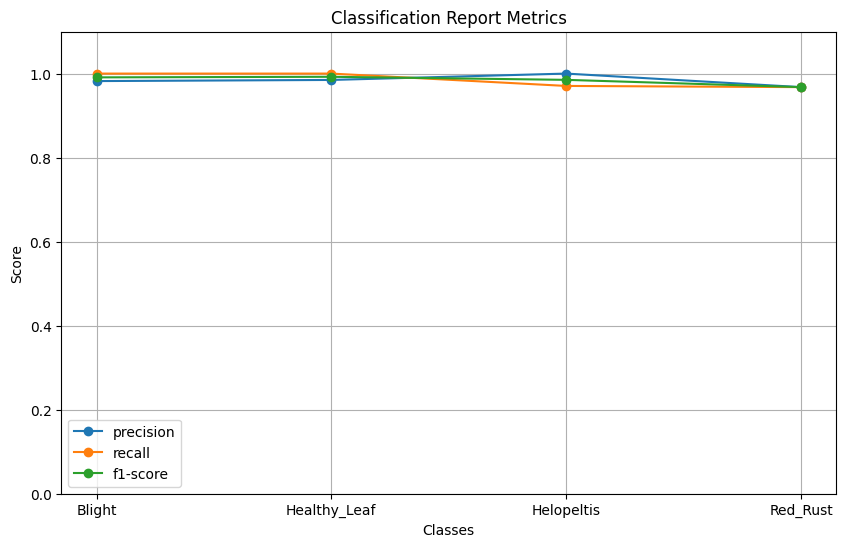

In [28]:
from sklearn.metrics import classification_report
import numpy as np

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(10,6))

for metric in metrics:
    scores = [report[cls][metric] for cls in class_names]
    plt.plot(class_names, scores, marker='o', label=metric)

plt.ylim(0, 1.1)
plt.title("Classification Report Metrics")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


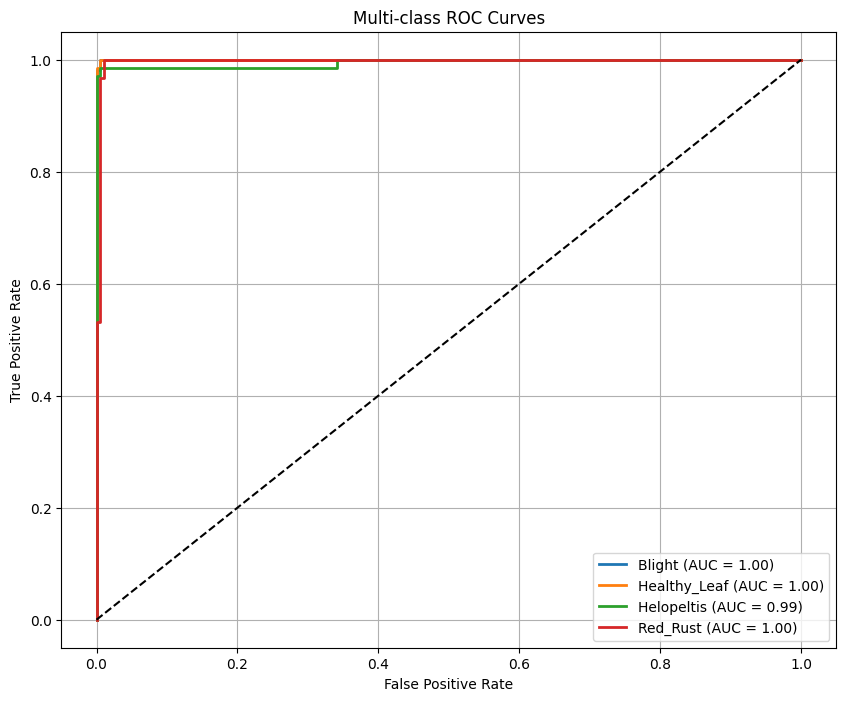

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Predict probabilities
y_pred_prob = model.predict(X_val)

plt.figure(figsize=(10,8))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.title('Multi-class ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


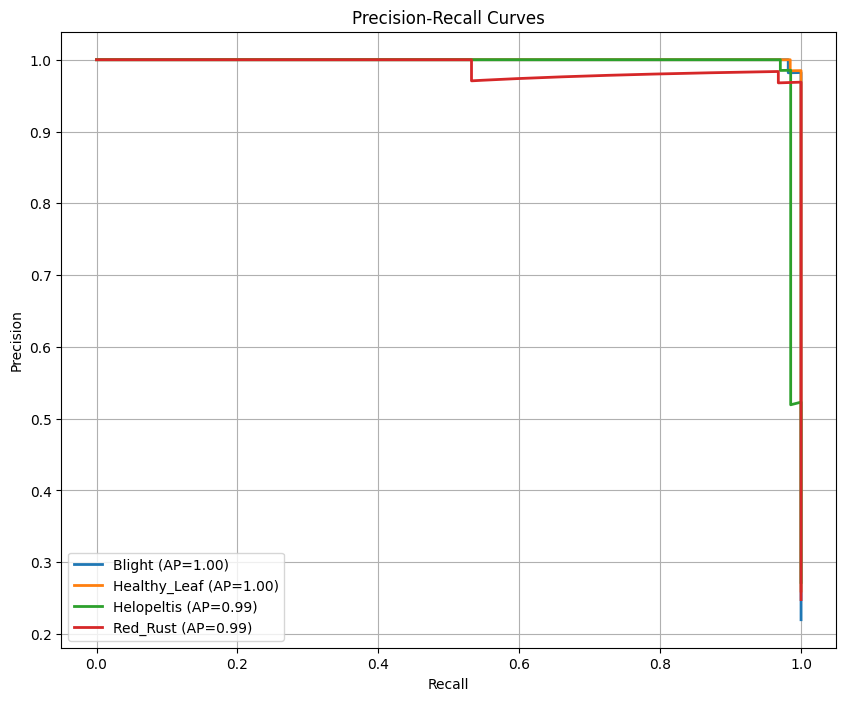

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={ap:.2f})')

plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
